# Classical Multidimensional Scaling

In [39]:
import pandas as pd
import numpy as np
from glob import glob
import ipywidgets
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the DataFrame with the Conformation type labels
- Check the previous notebook ([6_Label_CDK2_Crystal_Conformations.ipynb](./6_Label_CDK2_Crystal_Conformations.ipynb)) to see the process followed to label each PDB structure.

In [40]:
prot_name = 'cdk2'
file = f'./df_metadata_{prot_name}_pdbids_LIGS_CONF-LABELS.pkl'
df_prot = pd.read_pickle(file)
# keep only the relevant columns
columns = ['PDB_ID', 'Entities', 'Resolution', 
           'LigPktName', 'LigMW', 'LigNHeavyAtoms', 
           'ConfTypeLabel']
df_prot = df_prot[columns]

df_prot.head()

,PDB_ID,Entities,Resolution,LigPktName,LigMW,LigNHeavyAtoms,ConfTypeLabel
0,1aq1,1,2.0,STU,440.324600,35.0,inact_src
1,1b38,1,2.0,ATP,491.053983,31.0,inact_src
2,1b39,1,2.1,ATP,491.053983,31.0,inact_src
3,1buh,"1,2",2.6,None,NaN,NaN,inact_src
4,1ckp,1,2.05,PVB,249.614900,18.0,inact_src


In [41]:
df_prot.value_counts('ConfTypeLabel')

ConfTypeLabel
inact_src    292
active       120
inact_ope      5
dfg_out        1
dtype: int64

## Load all the PDB structures as a conformational ensemble
- Load all the conformations (`pdb` files) using `pytraj`

In [42]:
import pytraj as pyt

In [43]:
# Reference structure
ref_top_path  = f'../../data/crystal_confs/pdb_ensemble//1fin_ENS.pdb'
ref_conf = pyt.load(ref_top_path, 
                    ref_top_path)

In [44]:
ROOT_DIR = '../../data/crystal_confs/'

# Create a crystallographic ensemble (pseudo trajectory)
ENS_CONFS_DIR = f'{ROOT_DIR}/pdb_ensemble'
input_files = sorted(glob(f'{ENS_CONFS_DIR}/*_ENS.pdb'))

# Make sure the order of conformations in `input_files` 
# and `pdb_ids` is the same
input_files_basenames = [i.split('/')[-1].replace('_ENS.pdb', '') 
                         for i in input_files]
assert np.all(df_prot['PDB_ID'] == input_files_basenames)

In [45]:
# Use `pytraj` to load all conformations
crys_traj = pyt.iterload(input_files, top = ref_top_path)
crys_traj

pytraj.TrajectoryIterator, 418 frames: 
Size: 0.045295 (GB)
<Topology: 4848 atoms, 298 residues, 1 mols, non-PBC>
           

## Protein subsequences

In [46]:
import nglview as nv
from helper_modules.protein_subsequences import get_pisani_residues, \
                get_pocket_residues, get_secondary_structure_residues

# Create the atom selection masks
# TODO: Include a projection taking the A-loop into account
mask_secnd_strc = '(:' + get_secondary_structure_residues(sep = ',') + ')&(@CA)'
mask_pisani     = '(:' + get_pisani_residues(sep = ',') + ')&(@CA)'
mask_pkt_Ca     = '(:' + get_pocket_residues(sep = ',') + ')&(@CA)'
mask_pkt_noHs   = '(:' + get_pocket_residues(sep = ',') + ')&!(@H=)'
mask_Aloop      = '(:150-170)&(@CA)'

In [47]:
# Visualize the atom selections
ref_strc = '../../data/crystal_confs/pdb_ensemble/1aq1_ENS.pdb'

def view_atom_selection(selection: str = '', 
                        sel_color: str = 'red',
                        add_licorice: bool = False):
    view = nv.show_structure_file(ref_strc)
    view.clear_representations()
    view.add_cartoon(color = 'white')
    view.add_cartoon(color = sel_color,
        selection = selection)
    view.add_cartoon(color = 'green',
        selection = '150-170')
    if add_licorice:
        view.add_licorice(color = sel_color,
            selection = selection)
    view.center(selection = ':' + get_pocket_residues())
    view.control.zoom(-0.7)
    view._remote_call('setSize', target='Widget', args=['300px','400px'])
    view.camera='orthographic'
    return view

In [48]:
# All secondary structure residues
view1 = view_atom_selection(
            selection = ':' + get_secondary_structure_residues(),
            sel_color = 'red')
view2 = view_atom_selection(
            selection = ':' + get_pisani_residues(),
            sel_color = 'orange')
view3 = view_atom_selection(
            selection = ':' + get_pocket_residues(),
            sel_color = 'blue', add_licorice = True)
ipywidgets.HBox([view1, view2, view3])

## Classical Multidimensional Scaling
- Use the Crystal structures to define

In [49]:
from helper_modules.classical_MDS import cMDS, cMDS_projection

In [50]:
# Define a helper function to align, compute cMDS, and return the two first dimensions

# Compute the disimilarity matrix
def get_cMDS_proj(traj, mask_rmsd, 
                  mask_fit = None, 
                  normalize = True):
    if mask_fit != None:
        algn_traj = pyt.align(traj, mask = mask_fit)
        metric = 'nofit'
    else:
        algn_traj = traj
        metric ='rms'
    D_rmsd = pyt.pairwise_rmsd(traj = algn_traj,
                               mask = mask_rmsd, 
                               metric = metric)
    # Do min-max Normalization (to scale during visualization)
    if normalize:
        D_rmsd = (D_rmsd - np.min(D_rmsd)) / (np.max(D_rmsd) - np.min(D_rmsd))
    cmds = cMDS(D_rmsd)[0]
    return cmds

def plot_subspace(x, y, 
                  title = '', figsize = (8, 8), **kwargs):
    '''A simple scatterplot function'''
    fig, ax = plt.subplots(figsize = figsize)
    sns.scatterplot(x = x, y = y, 
                    linewidth = 0, color = '#02A298',
                    **kwargs
                   )
    ax.set_title(title)
    ax.set(xlabel = 'Dim. 1', ylabel = 'Dim. 2')
    ax.axvline(0, ls = ':', color = 'gray', lw = 2.5)
    ax.axhline(0, ls = ':', color = 'gray', lw = 2.5)
    ax.grid()
    return ax

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='talk')

In [52]:
type_confs_names  = ['inact_src', 'active', 'inact_ope', 'dfg_out']
ref_confs_names   = ['4fku', '1fin', '3pxf', '5a14']
ref_confs_colors  = ['#3DB8C1', '#EB5F5F',  '#FAB332', '#B389FA']
conf_label_colors = dict(zip(type_confs_names, ref_confs_colors))

In [53]:
mask  = '(@CA)&(:6-293)'
title = 'CDK2: cMDS using all residues (Ca atoms)'

def get_df_proj(traj, col_name, mask_rmsd, mask_fit):
    df_ = df_prot[['PDB_ID', 'ConfTypeLabel']].copy('deep')
    x, y = get_cMDS_proj(traj,
                    mask_rmsd, mask_fit)[:2]
    df_['AtomSelection'] = [col_name]*len(x)
    df_['x'] = x
    df_['y'] = y
    return df_

masks_names = {
    'Full Squence (Ca)'        : ('(@CA)&(:6-293)', None),
    'Secondary Structure (Ca)' : (mask_secnd_strc, None),
    'Pisani Res. (Ca)'         : (mask_pisani, None),
    'Pkt. (no Hs)'                 : (mask_pkt_noHs, None),
    'Pkt. (Ca)'                    : (mask_pkt_Ca, None),
    'Pkt. (no Hs) - Fit Pisani Ca' : (mask_pkt_noHs, mask_secnd_strc),
    'ALoop - Fit Secondary Ca'     : (mask_Aloop, mask_secnd_strc),
    'ALoop - Fit Pisani Ca'        : (mask_Aloop, mask_pisani),
    'ALoop - Fit Pkt Ca'           : (mask_Aloop, mask_pkt_Ca)
}

df_projs = pd.concat(
    [get_df_proj(crys_traj, col_name, mask_rmsd, mask_fit) 
     for col_name, (mask_rmsd, mask_fit)
     in masks_names.items()]
)

## Visualization

In [54]:
import plotly.express as px
from helper_modules.plotly_helpers import format_plotly

fig = px.scatter(df_projs, 
                 x="x", y="y", 
                 color="ConfTypeLabel", 
                 color_discrete_map = conf_label_colors,
                 facet_col_wrap = 3,
                 opacity = 0.8,
                 facet_col="AtomSelection",
                 hover_name = 'PDB_ID')
fig = format_plotly(fig, height = 1000, width = 1000)
fig.show()

# Selected subsequence 

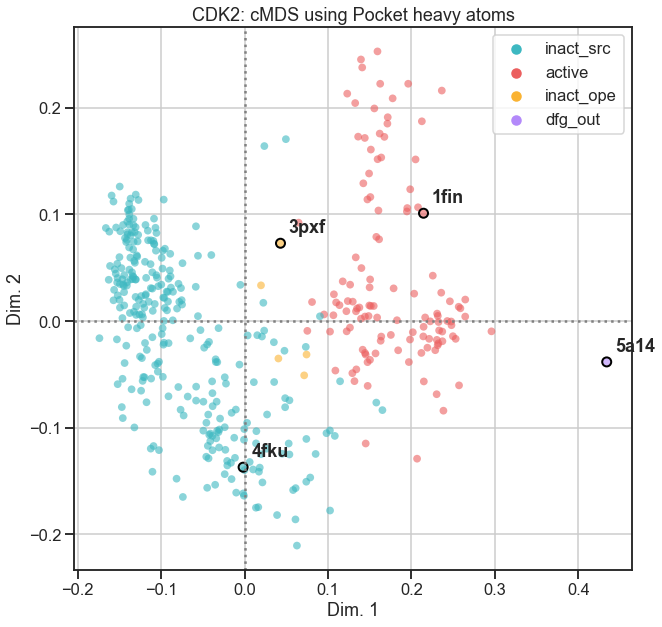

In [55]:
atom_selection =  'ConfTypeLabel'
title = 'CDK2: cMDS using Pocket heavy atoms'
df = df_projs.query('AtomSelection == "Pkt. (no Hs)"').set_index('PDB_ID')
ax = plot_subspace(df['x'], df['y'], 
    title = title, hue = df[atom_selection],
    s = 60, alpha = 0.6, palette = ref_confs_colors,
    figsize = (10, 10))
# Plot the reference conformations
df_ref_confs = df_prot.loc[[i in ref_confs_names 
                 for i in df_prot['PDB_ID']]]
df_ref_confs_idxs = df_ref_confs.index
sns.scatterplot(
    x = df['x'][df_ref_confs_idxs],
    y = df['y'][df_ref_confs_idxs],
    linewidth = 2, edgecolor = 'black',
    facecolors = 'none',
    ax = ax
)
for idx in df_ref_confs_idxs:
    plt.text(df['x'][idx] + 0.01, df['y'][idx] + 0.01, 
             s = df.index[idx], fontweight = 'bold')

plt.show()

# Principal Component Analysis
- **Show that PCA and cMDS can give a similar projection when using atom coordinates.**
- PCA will be more suitable were the number of samples is wide bigger than the number of variables.

In [56]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Extract coordinates from the trajectory
1. Use the desired atom group (atom `MASK`) to perform the alignment
2. Get the `xyz` coordinates of the trajectory: `shape = m*n*3`, with `n` = number of atoms, and `m` = number of frames.
3. Reshape the matrix coordinates to `shape = m*(n*3)`
4. Compute PCA and take the first two PCs

In [57]:
MASK = mask_pkt_noHs

crys_traj       = pyt.align(crys_traj, mask = MASK)
pkt_traj_coords = crys_traj[MASK].xyz
m, n, c         = pkt_traj_coords.shape
mtx_traj_traj   = pkt_traj_coords.reshape((m, n*c))

# Some print statemens
print(f'`xyz` shape: {pkt_traj_coords.shape}')
print(f'number of frames: {m}\nnumber of atoms: {n}')
print(f'Final shape: {mtx_traj_traj.shape}')

`xyz` shape: (418, 328, 3)
number of frames: 418
number of atoms: 328
Final shape: (418, 984)


## Pocket Selection
### Compute PCA

In [61]:
pca = PCA(n_components = 10)

mtx_traj_traj_scaled = mtx_traj_traj
pca_pkt_proj = pca.fit_transform(mtx_traj_traj_scaled)
exp_vars = pca.explained_variance_ratio_ * 100
var_cp1, var_cp2 = exp_vars[:2]

df = df_projs.query('AtomSelection == "Pkt. (no Hs)"').set_index('PDB_ID')
df['x_pca'] = pca_pkt_proj[:,0]
df['y_pca'] = pca_pkt_proj[:,1]

# Print explainded variance
print(f'Explained Variance:\nCP1: {var_cp1:.2f}%\nCP2: {var_cp2:.2f}%')

Explained Variance:
CP1: 22.09%
CP2: 9.40%


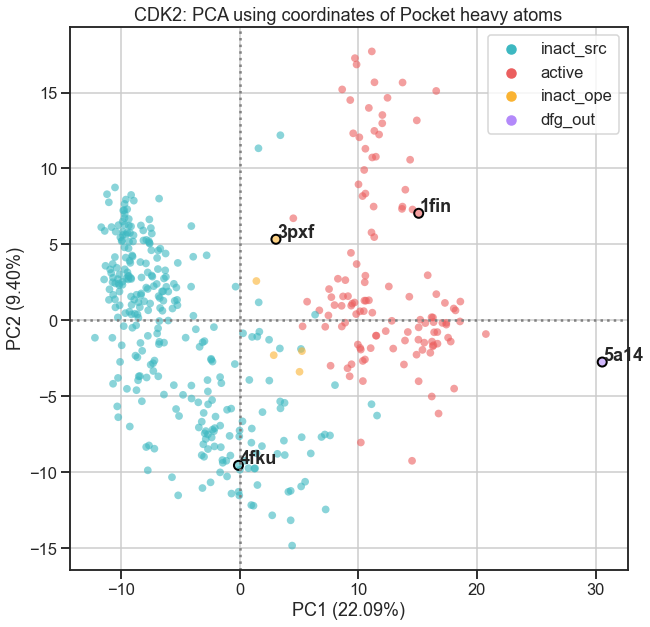

In [62]:
x = 'x_pca'
y = 'y_pca'
title = 'CDK2: PCA using coordinates of Pocket heavy atoms'

ax = plot_subspace(df[x], df[y], 
    title = title, hue = df[atom_selection],
    s = 60, alpha = 0.6, palette = ref_confs_colors,
    figsize = (10, 10))
# Plot the reference conformations
df_ref_confs = df_prot.loc[[i in ref_confs_names 
                 for i in df_prot['PDB_ID']]]
df_ref_confs_idxs = df_ref_confs.index
sns.scatterplot(
    x = df[x][df_ref_confs_idxs],
    y = df[y][df_ref_confs_idxs],
    linewidth = 2, edgecolor = 'black',
    facecolors = 'none',
    ax = ax
)
for idx in df_ref_confs_idxs:
    plt.text(df['x_pca'][idx] + 0.1, df['y_pca'][idx] + 0.1, 
             s = df.index[idx], fontweight = 'bold')
ax.set(xlabel = f'PC1 ({var_cp1:.2f}%)',
       ylabel = f'PC2 ({var_cp2:.2f}%)')
plt.show()

### Scree Plot

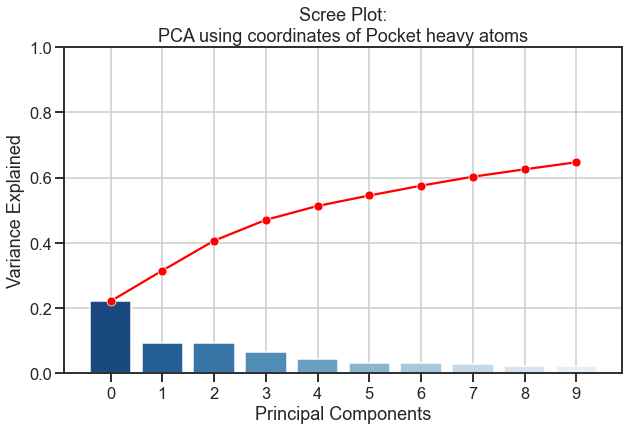

In [98]:
title = 'PCA using coordinates of Pocket heavy atoms'

PC_values = np.arange(pca.n_components_)
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
sns.barplot(x = PC_values, 
            y = pca.explained_variance_ratio_,
            palette = 'Blues_r', ax = ax)
sns.lineplot(x = PC_values, 
             y = pca.explained_variance_ratio_.cumsum(),
            color = 'red', marker = 'o', ax = ax)
ax.set_title(f'Scree Plot:\n{title}')
ax.set_xlabel('Principal Components')
ax.set_ylim((0, 1))
ax.grid()
ax.set_ylabel('Variance Explained')
plt.show()

## Pisani Selection

`xyz` shape: (418, 117, 3)
number of frames: 418
number of atoms: 117
Final shape: (418, 351)
Explained Variance:
CP1: 72.15%
CP2: 7.74%


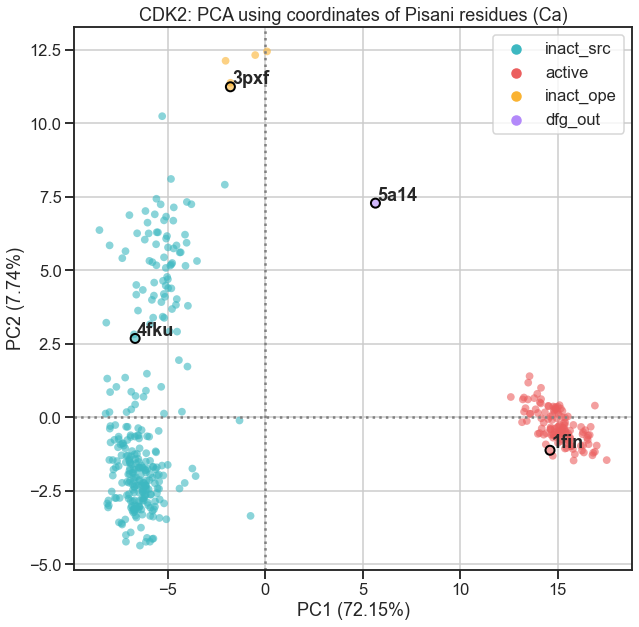

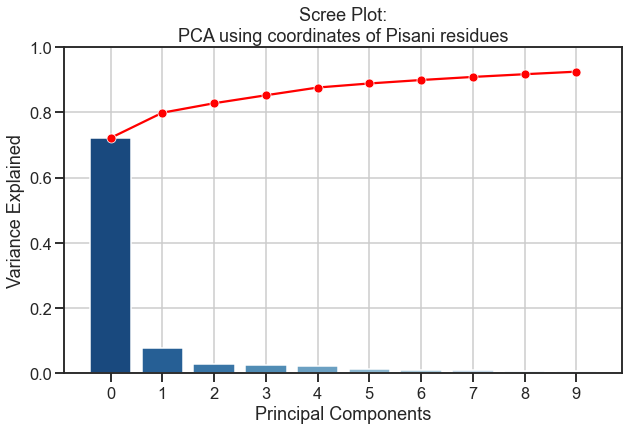

In [99]:
MASK = mask_pisani

crys_traj       = pyt.align(crys_traj, mask = MASK)
pkt_traj_coords = crys_traj[MASK].xyz
m, n, c         = pkt_traj_coords.shape
mtx_traj_traj   = pkt_traj_coords.reshape((m, n*c))

# Some print statemens
print(f'`xyz` shape: {pkt_traj_coords.shape}')
print(f'number of frames: {m}\nnumber of atoms: {n}')
print(f'Final shape: {mtx_traj_traj.shape}')

pca = PCA(n_components = 10)

mtx_traj_traj_scaled = mtx_traj_traj
pca_pkt_proj = pca.fit_transform(mtx_traj_traj_scaled)
exp_vars = pca.explained_variance_ratio_ * 100
var_cp1, var_cp2 = exp_vars[:2]

df = df_projs.query('AtomSelection == "Pkt. (no Hs)"').set_index('PDB_ID')
df['x_pca'] = pca_pkt_proj[:,0]
df['y_pca'] = pca_pkt_proj[:,1]

# Print explainded variance
print(f'Explained Variance:\nCP1: {var_cp1:.2f}%\nCP2: {var_cp2:.2f}%')

x = 'x_pca'
y = 'y_pca'
title = 'CDK2: PCA using coordinates of Pisani residues (Ca)'

ax = plot_subspace(df[x], df[y], 
    title = title, hue = df[atom_selection],
    s = 60, alpha = 0.6, palette = ref_confs_colors,
    figsize = (10, 10))
# Plot the reference conformations
df_ref_confs = df_prot.loc[[i in ref_confs_names 
                 for i in df_prot['PDB_ID']]]
df_ref_confs_idxs = df_ref_confs.index
sns.scatterplot(
    x = df[x][df_ref_confs_idxs],
    y = df[y][df_ref_confs_idxs],
    linewidth = 2, edgecolor = 'black',
    facecolors = 'none',
    ax = ax
)
for idx in df_ref_confs_idxs:
    plt.text(df['x_pca'][idx] + 0.1, df['y_pca'][idx] + 0.1, 
             s = df.index[idx], fontweight = 'bold')
ax.set(xlabel = f'PC1 ({var_cp1:.2f}%)',
       ylabel = f'PC2 ({var_cp2:.2f}%)')
plt.show()

title = 'PCA using coordinates of Pisani residues'

PC_values = np.arange(pca.n_components_)
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
sns.barplot(x = PC_values, 
            y = pca.explained_variance_ratio_,
            palette = 'Blues_r', ax = ax)
sns.lineplot(x = PC_values, 
             y = pca.explained_variance_ratio_.cumsum(),
            color = 'red', marker = 'o', ax = ax)
ax.set_title(f'Scree Plot:\n{title}')
ax.set_xlabel('Principal Components')
ax.set_ylim((0, 1))
ax.grid()
ax.set_ylabel('Variance Explained')
plt.show()